# CNN LSTM Model

50.039 Theory and Practice of Deep Learning Project

In [1]:
!pip install torchinfo

  Using cached torchinfo-1.5.4-py3-none-any.whl (19 kB)


In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from Preprocessor import *
from Constants import *
from MelTrainHelper import Train_Helper
#from Plot import generate_plot

from tqdm import tqdm
from torchinfo import summary
from IPython.display import Audio
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
#Convert Dataset into Pandas Dataframe
Tess = "./TESS"

tess_directory_list = os.listdir(Tess)
preprocessor = DataPreprocessor()   
file_paths, labels = preprocessor.get_file_paths_and_labels(Tess)

EMOTIONS= {'neutral':0,'happy':1, 'sad':2, 'angry':3, 'fear':4, 'disgust':5, 'ps':6}
encoded_labels = [EMOTIONS[label] for label in labels]
emotion_df = pd.DataFrame(labels, columns=['Emotions'])
print("ALL EMOTIONS:", set(labels))

path_df = pd.DataFrame(file_paths, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

ALL EMOTIONS: {'neutral', 'happy', 'disgust', 'ps', 'sad', 'fear', 'angry'}


,Emotions,Path
0,sad,./TESS/YAF_sad/YAF_wife_sad.wav
1,sad,./TESS/YAF_sad/YAF_hate_sad.wav
2,sad,./TESS/YAF_sad/YAF_phone_sad.wav
3,sad,./TESS/YAF_sad/YAF_week_sad.wav
4,sad,./TESS/YAF_sad/YAF_raid_sad.wav


# Dataset

In [ ]:
# #Convert Dataset into Pandas Dataframe
# RAVDESS = "./RAVDESS"

# preprocessor = DataPreprocessor()   
# file_paths, labels = preprocessor.get_file_paths_and_labels_RAVDESS(RAVDESS)

# CREMA_D_EMOTION_ENCODING = {'FEA':0,'DIS':1, 'HAP':2, 'SAD':3, 'ANG':4, 'NEU':5}
# encoded_labels = [CREMA_D_EMOTION_ENCODING[label] for label in labels]
# emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# print("ALL EMOTIONS:", set(labels))

# path_df = pd.DataFrame(file_paths, columns=['Path'])
# CREMA_D_df = pd.concat([emotion_df, path_df], axis=1)
# CREMA_D_df.head()

In [ ]:
# #Convert Dataset into Pandas Dataframe
# CREMA_D = "./CREMA_D"

# preprocessor = DataPreprocessor()   
# file_paths, labels = preprocessor.get_file_paths_and_labels_CREMA(CREMA_D)

# CREMA_D_EMOTION_ENCODING = {'FEA':0,'DIS':1, 'HAP':2, 'SAD':3, 'ANG':4, 'NEU':5}
# encoded_labels = [CREMA_D_EMOTION_ENCODING[label] for label in labels]
# emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# print("ALL EMOTIONS:", set(labels))

# path_df = pd.DataFrame(file_paths, columns=['Path'])
# CREMA_D_df = pd.concat([emotion_df, path_df], axis=1)
# CREMA_D_df.head()

# Data Preprocessing

In [ ]:
# #Extracting mel spectrograms from Dataset
# signals = preprocessor.extract_audio_signals(Tess_df['Path'])
# #signals = preprocessor.extract_audio_signals(Tess_df['Path'])
# mel_spectograms = preprocessor.extract_mel_spectograms(signals)

In [ ]:
# # Rune only if the converted mel_spectrograms are not saved into numpy array yet
# with open('crema_mel_spec_all.npy', 'wb') as f:
#     np.save(f, mel_spectograms)

In [3]:
with open('mel_spec_all.npy', 'rb') as f:
    mel_spectograms = np.load(f)

In [4]:
#Spliting extracted mel spectrogram data into training, testing and validation set
X_train, X_val, X_test, Y_train, Y_val, Y_test = preprocessor.train_val_test_split(mel_spectograms, encoded_labels)
#Scaling and reshape Data for training
X_train = preprocessor.reshape_scale_data(X_train)
X_test = preprocessor.reshape_scale_data(X_test)
X_val = preprocessor.reshape_scale_data(X_val)

# Create the model

In [5]:
class CNN_LSTM(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        hidden_size = 128
        
        conv2d_1 = nn.Conv2d(in_channels=1, out_channels=16, stride=1, padding=1, kernel_size=3)
        conv2d_2 = nn.Conv2d(in_channels=16, out_channels=32, stride=1, padding=1, kernel_size=3)
        conv2d_3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, padding=1, kernel_size=3)
        conv2d_4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, padding=1, kernel_size=3)
        relu = nn.ReLU()
        maxPool2_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        maxPool4_4 = nn.MaxPool2d(kernel_size=4, stride=4)
        dropOut = nn.Dropout(p=0.1)
        batchNorm16 = nn.BatchNorm2d(16)
        batchNorm32 = nn.BatchNorm2d(32)
        batchNorm64 = nn.BatchNorm2d(64)
        
        #Convolution Block
        self.conv2Dblock = nn.Sequential(conv2d_1, batchNorm16, relu, maxPool2_2, dropOut,
                                         conv2d_2, batchNorm32, relu, maxPool4_4, dropOut,
                                         conv2d_3, batchNorm64, relu, maxPool4_4, dropOut,
                                         conv2d_4, batchNorm64, relu, maxPool4_4, dropOut)
        
        #LSTM Block
        self.maxpool_lstm = nn.MaxPool2d(stride=[2,4], kernel_size=[2,4])
        self.lstm = nn.LSTM(input_size=64,
                            bidirectional=True,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1)
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0.1)
        self.out_softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        #Convolutional
        conv_out = self.conv2Dblock(x)
        conv_out = torch.flatten(conv_out, start_dim=1)
        #LSTM
        x_maxpool = self.maxpool_lstm(x)
        x_squeeze = torch.squeeze(x_maxpool,1)
        x_permute = x_squeeze.permute(0,2,1)
        lstm_out, (h,c) = self.lstm(x_permute)
        lstm_out = self.dropout_lstm(lstm_out)
        batch_size, T, _ = lstm_out.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_out[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_out)
        attention = torch.squeeze(attention, 1)
        # Concatenate CNN & LSTM Part
        complete_out = torch.cat([conv_out, attention], dim=1) 
        
        output_logits = self.out_linear(complete_out)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax #, attention_weights_norm

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
train_helper = Train_Helper()

cuda


# Learning Stopping Implementation

In [ ]:
# from torchsample.modules import ModuleTrainer
# trainer = ModuleTrainer(model)
# model = ModuleTrainer(Network())
# model.compile(loss='nll_loss', optimizer='adam')
# callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
# model.set_callbacks(callbacks)
# model.fit(x_train, y_train, val_data=(x_test, y_test),num_epoch=200, batch_size=128, verbose=1)
# loss = model.evaluate(x_train, y_train)
# y_pred = model.predict(x_train)

# TRAINING

In [7]:
model = CNN_LSTM(num_emotions=7).to(device)
epochs= 150
batch_size = 32
trained_model, losses, val_losses , train_acc, val_acc = train_helper.model_train(model, epochs, batch_size, train_helper.loss_func,  X_train, Y_train, X_val, Y_val, device)

Number of trainable params:  262952
 Epoch 0: iteration 69/70
Epoch 0 --> loss:1.9886, acc:17.54%, val_loss:2.0226, val_acc:14.29%
 Epoch 1: iteration 69/70
Epoch 1 --> loss:2.0223, acc:14.33%, val_loss:2.0226, val_acc:14.29%
 Epoch 2: iteration 69/70
Epoch 2 --> loss:2.0212, acc:14.46%, val_loss:2.0226, val_acc:14.29%
 Epoch 3: iteration 69/70
Epoch 3 --> loss:2.0202, acc:14.42%, val_loss:2.0226, val_acc:14.29%
 Epoch 4: iteration 69/70
Epoch 4 --> loss:2.0229, acc:14.24%, val_loss:2.0226, val_acc:14.29%
 Epoch 5: iteration 69/70
Epoch 5 --> loss:2.0250, acc:14.15%, val_loss:2.0226, val_acc:14.29%
 Epoch 6: iteration 69/70
Epoch 6 --> loss:2.0246, acc:14.06%, val_loss:2.0226, val_acc:14.29%
 Epoch 7: iteration 69/70
Epoch 7 --> loss:2.0194, acc:14.55%, val_loss:2.0226, val_acc:14.29%
 Epoch 8: iteration 69/70
Epoch 8 --> loss:2.0221, acc:14.33%, val_loss:2.0226, val_acc:14.29%
 Epoch 9: iteration 69/70
Epoch 9 --> loss:2.0203, acc:14.42%, val_loss:2.0226, val_acc:14.29%
 Epoch 10: ite

 Epoch 85: iteration 69/70
Epoch 85 --> loss:2.0248, acc:13.93%, val_loss:2.0226, val_acc:14.29%
 Epoch 86: iteration 69/70
Epoch 86 --> loss:2.0168, acc:14.78%, val_loss:2.0226, val_acc:14.29%
 Epoch 87: iteration 69/70
Epoch 87 --> loss:2.0196, acc:14.42%, val_loss:2.0226, val_acc:14.29%
 Epoch 88: iteration 69/70
Epoch 88 --> loss:2.0190, acc:14.55%, val_loss:2.0226, val_acc:14.29%
 Epoch 89: iteration 69/70
Epoch 89 --> loss:2.0218, acc:14.33%, val_loss:2.0226, val_acc:14.29%
 Epoch 90: iteration 69/70
Epoch 90 --> loss:2.0269, acc:13.88%, val_loss:2.0226, val_acc:14.29%
 Epoch 91: iteration 69/70
Epoch 91 --> loss:2.0190, acc:14.64%, val_loss:2.0226, val_acc:14.29%
 Epoch 92: iteration 69/70
Epoch 92 --> loss:2.0207, acc:14.42%, val_loss:2.0226, val_acc:14.29%
 Epoch 93: iteration 69/70
Epoch 93 --> loss:2.0236, acc:14.15%, val_loss:2.0226, val_acc:14.29%
 Epoch 94: iteration 69/70
Epoch 94 --> loss:2.0211, acc:14.33%, val_loss:2.0226, val_acc:14.29%
 Epoch 95: iteration 69/70
Epo

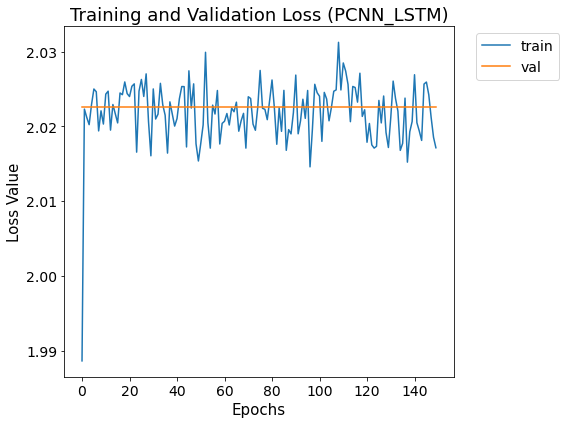

In [10]:
generate_plot(losses, val_losses, "PCNN_LSTM_150e_32b_loss_dp0.1_lr0.1", typ='loss', model='PCNN_LSTM')

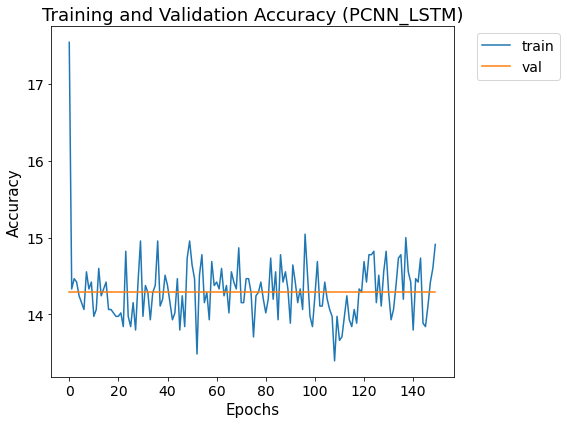

In [11]:
generate_plot(train_acc, val_acc, "PCNN_LSTM_150e_32b_acc_dp0.5_lr0.1", typ='acc',model='PCNN_LSTM')

# Saving the trained model's weights

In [12]:
saved_trained_weights_file = "PCNN_LSTM_150e_32b_dp0.1_lr0.1.pt"

os.makedirs('models', exist_ok=True)
file_path = os.path.join(os.getcwd(),'models')
torch.save(trained_model.state_dict(), os.path.join(file_path, saved_trained_weights_file))
print('Trained Weights saved to'.format(os.path.join(file_path, saved_trained_weights_file)))

Trained Weights saved to


# Loading model's weights

In [20]:
loaded_trained_weights_file = "PCNN_LSTM_150e_32b_dp0.1_lr0.01.pt"

LOAD_PATH = os.path.join(os.getcwd(),'models')
model = CNN_LSTM(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, loaded_trained_weights_file)))
print('Weights for Model is loaded from {}'.format(os.path.join(LOAD_PATH, loaded_trained_weights_file)))

Weights for Model is loaded from /home/jovyan/DL Project/models/PCNN_LSTM_150e_32b_dp0.1.pt


In [63]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Dropout: 2-5                      --
│    └─Conv2d: 2-6                       4,640
│    └─BatchNorm2d: 2-7                  64
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
│    └─Dropout: 2-10                     --
│    └─Conv2d: 2-11                      18,496
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Dropout: 2-15                     --
│    └─Conv2d: 2-16                      36,928
│    └─BatchNorm2d: 2-17                 (recursive)
│    └─ReLU: 2-18                        --
│    └─MaxPool2d: 2-19                   --
│    

# Testing

In [13]:
validate = train_helper.make_validate_func(model, train_helper.loss_func)
X_test_tensor = torch.tensor(X_test,device="cuda").float()
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long, device="cuda")
testing_loss, testing_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Testing loss is {testing_loss:.6f}')
print(f'Testing accuracy is {testing_acc:.6f}%')

Testing loss is 2.022565
Testing accuracy is 14.285715%


In [7]:
def infer(model, path, all_mel_specs):
    EMOTIONS= {0:'neutral',1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'disgust', 6:'ps'}
    n=len(path)
    train_helper = Train_Helper()
    preprocessor = DataPreprocessor()
    validate_top3 = train_helper.make_validate_func_top3(model,train_helper.loss_func)
    if len(path) == 1:
        path = path[0]
        audio, sample_rate = librosa.load(path, duration=3, offset=0.5, sr=48000)
        audio_signal = np.zeros((int(sample_rate*3,)))
        audio_signal[:len(audio)] = audio
        mel_specs = preprocessor.extract_mel_spectogram(audio_signal)
        X_test = mel_specs
        X_test = np.expand_dims(X_test, axis=0)
        X_test = np.concatenate((X_test, all_mel_specs))
        X_test = preprocessor.reshape_scale_data(X_test)
        X_test = X_test[:1]
    else:
        audio_signals = preprocessor.extract_audio_signals(path)
        mel_specs = preprocessor.extract_mel_spectograms(audio_signals)
        mel_specs = np.concatenate((mel_specs, all_mel_specs))
        X_test = preprocessor.reshape_scale_data(mel_specs)
        X_test = X_test[:len(path)]
    Y_test = [1]*n
    X_test_tensor = torch.tensor(X_test,device='cpu').float()
    Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device='cpu')
    test_loss, test_acc, predictions, output_softmax = validate_top3(X_test_tensor,Y_test_tensor)
    
    if len(predictions.tolist()) == 1:
        ground_truth = path.split("_")[-1].split(".")[-2]
        top3_prob, top3 = torch.topk(output_softmax, 3)
        top3 = top3.detach().numpy()
        top3_prob = top3_prob.detach().numpy()
        print("Audio File: ", path)
        print("Predicted Emotions: ",EMOTIONS[top3[0,0]], "\t| Ground Truth: ", ground_truth)
        print("Top 1: ", EMOTIONS[top3[0,0]], "Prob: ", round(top3_prob[0,0]*100, 3),"%", "\t| Top 2: ", EMOTIONS[top3[0,1]], "Prob: ", round(top3_prob[0,1]*100, 3),"%", "\t| Top 3: ", EMOTIONS[top3[0,2]], "Prob: ", round(top3_prob[0,2]*100, 3),"%")
    else:
        print("\n")
        i = 0 
        for pred, file_name in zip(predictions.tolist(), path):
            ground_truth = file_name.split("_")[-1].split(".")[-2]
            
            top3_prob, top3 = torch.topk(output_softmax[i], 3)
            top3 = top3.detach().numpy()
            top3_prob = top3_prob.detach().numpy()
            i += 1
            print("Audio File: ", file_name)
            print("Predicted Emotions: ",EMOTIONS[top3[0]], "\t| Ground Truth: ", ground_truth)
            print("Top 1:", EMOTIONS[top3[0]], "(Prob:", round(top3_prob[0]*100, 2),"%)", "\t| Top 2:", EMOTIONS[top3[1]], "(Prob:", round(top3_prob[1]*100, 2),"%)", "\t| Top 3:", EMOTIONS[top3[2]], "(Prob:", round(top3_prob[2]*100, 2),"%)\n")
    return

# Confusion Matrix

In [15]:
predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
print(EMOTIONS)
EMOTIONS= {0:'neutral',1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'disgust', 6:'ps'}
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

# Plot loss

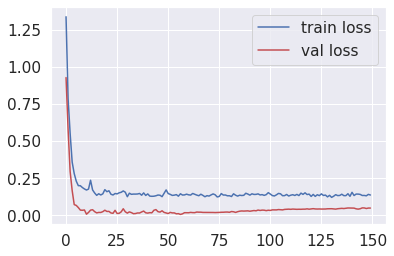

In [33]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

# Visualizing mel spectrograms

In [ ]:
audio = preprocessor.extract_audio_signals(["./TESS/YAF_happy/YAF_wife_happy.wav"])

Audio(Y,rate=48000)

In [ ]:
librosa.display.specshow(mel_spectograms[2].squeeze(), y_axis='mel', x_axis='time',cmap='magma')
Audio(audio,rate=48000)

# Inferring Single or Multiple Samples

In [11]:
#Inferring Single Sample
#single_test = "./TESS/YAF_sad/YAF_wife_sad.wav"
single_test = "./CREMA_D/happy/1004_IEO_HAP_LO.wav"
infer(model,[single_test],mel_spectograms)
audio = preprocessor.extract_audio_signals([single_test])
Audio(audio,rate=48000)

Audio File:  ./CREMA_D/happy/1004_IEO_HAP_LO.wav
Predicted Emotions:  disgust 	| Ground Truth:  LO
Top 1:  disgust Prob:  54.003 % 	| Top 2:  ps Prob:  41.182 % 	| Top 3:  neutral Prob:  2.27 %
 extract_audio_signals: Processed 0/1 files

In [62]:
#Inferring a list of Samples
file_ls = ["./TESS/YAF_sad/YAF_wife_sad.wav","./TESS/YAF_fear/YAF_wife_fear.wav","./TESS/YAF_happy/YAF_wife_happy.wav","./TESS/YAF_neutral/YAF_wife_neutral.wav"]
infer(model, file_ls ,mel_spectograms)

 extract_mel_spectograms: Processed 3/4 files

Audio File:  ./TESS/YAF_sad/YAF_wife_sad.wav
Predicted Emotions:  sad 	| Ground Truth:  sad
Top 1: sad (Prob: 99.77 %) 	| Top 2: angry (Prob: 0.06 %) 	| Top 3: fear (Prob: 0.06 %)

Audio File:  ./TESS/YAF_fear/YAF_wife_fear.wav
Predicted Emotions:  fear 	| Ground Truth:  fear
Top 1: fear (Prob: 99.92 %) 	| Top 2: angry (Prob: 0.04 %) 	| Top 3: ps (Prob: 0.02 %)

Audio File:  ./TESS/YAF_happy/YAF_wife_happy.wav
Predicted Emotions:  happy 	| Ground Truth:  happy
Top 1: happy (Prob: 100.0 %) 	| Top 2: angry (Prob: 0.0 %) 	| Top 3: fear (Prob: 0.0 %)

Audio File:  ./TESS/YAF_neutral/YAF_wife_neutral.wav
Predicted Emotions:  neutral 	| Ground Truth:  neutral
Top 1: neutral (Prob: 98.16 %) 	| Top 2: angry (Prob: 0.85 %) 	| Top 3: ps (Prob: 0.69 %)



In [13]:
#Inferring a folder of Samples
folder_name = "./TESS/YAF_happy/"
#folder_name = "./CREMA_D/happy/"
folder = os.listdir(folder_name)
folder = [folder_name+file for file in folder]
infer(model, folder, mel_spectograms)

 extract_mel_spectograms: Processed 499/500 files

Audio File:  ./CREMA_D/happy/1015_ITS_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 85.94 %) 	| Top 2: fear (Prob: 5.46 %) 	| Top 3: angry (Prob: 5.38 %)

Audio File:  ./CREMA_D/happy/1025_IWW_HAP_XX.wav
Predicted Emotions:  ps 	| Ground Truth:  XX
Top 1: ps (Prob: 59.73 %) 	| Top 2: disgust (Prob: 24.68 %) 	| Top 3: angry (Prob: 7.03 %)

Audio File:  ./CREMA_D/happy/1046_IOM_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 50.21 %) 	| Top 2: fear (Prob: 33.33 %) 	| Top 3: neutral (Prob: 11.04 %)

Audio File:  ./CREMA_D/happy/1018_ITH_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 39.08 %) 	| Top 2: fear (Prob: 32.28 %) 	| Top 3: ps (Prob: 26.33 %)

Audio File:  ./CREMA_D/happy/1074_IEO_HAP_HI.wav
Predicted Emotions:  ps 	| Ground Truth:  HI
Top 1: ps (Prob: 96.8 %) 	| Top 2: fear (Prob: 1.32 %) 	| Top 3: angry (Prob: 1.06 %)

Aud

Top 1: disgust (Prob: 78.71 %) 	| Top 2: ps (Prob: 15.56 %) 	| Top 3: sad (Prob: 2.79 %)

Audio File:  ./CREMA_D/happy/1038_IEO_HAP_LO.wav
Predicted Emotions:  ps 	| Ground Truth:  LO
Top 1: ps (Prob: 75.38 %) 	| Top 2: disgust (Prob: 17.33 %) 	| Top 3: neutral (Prob: 3.7 %)

Audio File:  ./CREMA_D/happy/1004_WSI_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 50.28 %) 	| Top 2: ps (Prob: 48.12 %) 	| Top 3: fear (Prob: 1.23 %)

Audio File:  ./CREMA_D/happy/1067_TAI_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 36.46 %) 	| Top 2: ps (Prob: 31.37 %) 	| Top 3: sad (Prob: 21.45 %)

Audio File:  ./CREMA_D/happy/1043_TIE_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 64.03 %) 	| Top 2: ps (Prob: 33.65 %) 	| Top 3: sad (Prob: 1.0 %)

Audio File:  ./CREMA_D/happy/1039_IEO_HAP_MD.wav
Predicted Emotions:  ps 	| Ground Truth:  MD
Top 1: ps (Prob: 68.32 %) 	| Top 2: disgust (Prob: 18.97 %) 	

Top 1: disgust (Prob: 89.02 %) 	| Top 2: ps (Prob: 6.7 %) 	| Top 3: fear (Prob: 2.63 %)

Audio File:  ./CREMA_D/happy/1075_TIE_HAP_XX.wav
Predicted Emotions:  sad 	| Ground Truth:  XX
Top 1: sad (Prob: 52.94 %) 	| Top 2: disgust (Prob: 46.98 %) 	| Top 3: ps (Prob: 0.08 %)

Audio File:  ./CREMA_D/happy/1033_IWL_HAP_XX.wav
Predicted Emotions:  ps 	| Ground Truth:  XX
Top 1: ps (Prob: 61.82 %) 	| Top 2: disgust (Prob: 36.32 %) 	| Top 3: fear (Prob: 1.3 %)

Audio File:  ./CREMA_D/happy/1073_IEO_HAP_MD.wav
Predicted Emotions:  disgust 	| Ground Truth:  MD
Top 1: disgust (Prob: 45.06 %) 	| Top 2: ps (Prob: 40.41 %) 	| Top 3: neutral (Prob: 11.15 %)

Audio File:  ./CREMA_D/happy/1017_IWW_HAP_XX.wav
Predicted Emotions:  angry 	| Ground Truth:  XX
Top 1: angry (Prob: 44.04 %) 	| Top 2: sad (Prob: 17.86 %) 	| Top 3: ps (Prob: 15.6 %)

Audio File:  ./CREMA_D/happy/1005_IWW_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 94.16 %) 	| Top 2: ps (Prob: 4.53 %) 	| To

Top 1: ps (Prob: 94.88 %) 	| Top 2: disgust (Prob: 3.45 %) 	| Top 3: neutral (Prob: 0.61 %)

Audio File:  ./CREMA_D/happy/1067_IWL_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 90.74 %) 	| Top 2: ps (Prob: 6.41 %) 	| Top 3: sad (Prob: 1.75 %)

Audio File:  ./CREMA_D/happy/1049_IWW_HAP_XX.wav
Predicted Emotions:  ps 	| Ground Truth:  XX
Top 1: ps (Prob: 62.42 %) 	| Top 2: disgust (Prob: 15.85 %) 	| Top 3: fear (Prob: 15.55 %)

Audio File:  ./CREMA_D/happy/1050_IWL_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 81.46 %) 	| Top 2: ps (Prob: 16.3 %) 	| Top 3: sad (Prob: 1.15 %)

Audio File:  ./CREMA_D/happy/1042_TSI_HAP_XX.wav
Predicted Emotions:  ps 	| Ground Truth:  XX
Top 1: ps (Prob: 87.75 %) 	| Top 2: happy (Prob: 3.39 %) 	| Top 3: disgust (Prob: 3.0 %)

Audio File:  ./CREMA_D/happy/1025_MTI_HAP_XX.wav
Predicted Emotions:  disgust 	| Ground Truth:  XX
Top 1: disgust (Prob: 93.06 %) 	| Top 2: ps (Prob: 3.55 %) 	| 

In [9]:
def generate_plot(train, val, filename, typ='loss', model='MLP', savepath='figs/'):
    if len(train) != len(val):
        raise Exception("Input data arrays of different length.")
    
    # params
    nepochs = len(train)
    title_fontsize = '18'
    label_fontsize = '15'
    xtick_fontsize = '14'
    ytick_fontsize = '14'
    
    fig = plt.figure(figsize=(8,6))
    x = np.arange(nepochs)
    
    plt.plot(x, train, label='train')
    plt.plot(x, val, label='val')
    
    if typ == 'loss':
        title = 'Training and Validation Loss'
        ylabel = 'Loss Value'
    elif typ == 'acc':
        title = 'Training and Validation Accuracy'
        ylabel = 'Accuracy'
        
    title = title + ' ' + '(' + model + ')'
        
    xlabel = 'Epochs'
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(fontsize=xtick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)
    plt.legend(fontsize=ytick_fontsize, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
    plt.savefig('./Figs/' + filename + '.png', dpi=250)
    plt.show()